In [32]:
#!pip install selenium

In [2]:
# Importing a driver from selenium that will help us in scrapping the website
from selenium import webdriver

# Importing service to specify the driver executable path
from selenium.webdriver.chrome.service import Service

# Importing library to locate web element on webpage
from selenium.webdriver.common.by import By

# Importing library to parse the html content
from bs4 import BeautifulSoup

# Importing basic libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
# Initialize empty lists to store scraped data
titles = []
companies = []
locations = []
salaries = []
links = []


# Loop through multiple pages of job listings (0 to 2000 in steps of 10)
for i in range(0,2000, 10):
   # Specify the link to scrape job listings
    website=f'https://in.indeed.com/jobs?q=python+developer&l=india&start={str(i)}&pp=gQAPAAAAAAAAAAAAAAACFkHNeQAqAQEBCAP-b2C0q9L9XIftjS7t-672oyCu9Hr4-oc8MXga9Zyg1MaQrpNMAAA&vjk=a385f7b9bdeadeea'
   # Specify the path to the Chrome WebDriver
    driverlocation=r"D:\chromedriver-win64\chromedriver.exe"
   # Create a service to specify the driver executable path
    service = Service(driverlocation)
   # Create ChromeOptions and specify options, including headless mode
    chrome_options = webdriver.ChromeOptions()
   # Initialize the Chrome WebDriver with service and options
    driver = webdriver.Chrome(service=service, options=chrome_options)
   # Open the webpage
    driver.get(website)
   # Locate elements with "ul" tag
    all_jobs = driver.find_elements(By.TAG_NAME, "ul")
   # Loop through all of the jobs listed on the page
    for job_list in all_jobs:
   # Capture the content available in an element
        result_html = job_list.get_attribute("innerHTML")
   # Parse the HTML content using BeautifulSoup
        soup = BeautifulSoup(result_html, 'html.parser')
   # Select all "div" tags with a particular class on the page
        jobs = soup.find_all('div', class_="job_seen_beacon")
    
   # Loop through content available for a job
        for job in jobs:
         # Try to extract the job title
            try:
                title = job.find("span").text
            except:
                title = "None"
            titles.append(title)
            
            # Try to extract the company name
            try: 
                company_name = job.find("div", class_="company_location css-12lvszk e37uo190")
                company = company_name.find("span").text
            except:
                company = "None"
            companies.append(company)
            
            # Try to extract the job location
            try:
                location = company_name.find("div")
                location = location.find("div").text
            except:
                location = "None"
            locations.append(location)
            # Try to extract the job salary
            try:
                salary = job.find("div", class_="css-1ihavw2 eu4oa1w0").text
            except:
                salary = "None"
            salaries.append(salary)
            
            # Try to extract the job link
            try:
                link = job.find("a").attrs["href"]
            except:
                link = "None"
            links.append(link)
    # Close the webpage
    driver.quit()       

In [18]:
# Creating a dfframe for scrapped df

df = pd.DataFrame([titles,companies,locations,salaries,links]).T
df.columns = ["Title","Company","Location","Salary","Job Link"]
df

,Title,Company,Location,Salary,Job Link
0,Automation Developer,Deloitte,"Bengaluru, Karnataka",None,/pagead/clk?mo=r&ad=-6NYlbfkN0DIXU_djF9v0NrX_x...
1,DevOps - Specialist / Sr. Specialist,Colgate-Palmolive,"Mumbai, Maharashtra",None,/pagead/clk?mo=r&ad=-6NYlbfkN0CScSxRBn_n5hzPBw...
2,Senior Software Engineer,ARM,"Bengaluru, Karnataka",None,/pagead/clk?mo=r&ad=-6NYlbfkN0BgJnowPS_nFa6Jvb...
3,"Director, Site Reliability Engineering",NetApp,"Bengaluru, Karnataka",Rotational shift,/pagead/clk?mo=r&ad=-6NYlbfkN0DUIUKNmkO9eplQBW...
4,Python Developer,BigShyft,"Bengaluru, Karnataka","₹7,00,000 - ₹15,00,000 a year",/rc/clk?jk=0394ace2c560bb47&fccid=df4303b9957b...
...,...,...,...,...,...
70,Senior Python Developer,American Chase LLP,"Remote in Bengaluru, Karnataka",₹700 - ₹900 an hour,/company/American-Chase-LLP/jobs/Python-Develo...
71,Python/Django Developer,Cariva Technologies,"Bengaluru, Karnataka","₹80,000 - ₹1,30,000 a month",/company/Cariva-Technologies-Pvt.-Ltd./jobs/Py...
72,Intern - Raspberry Pi/Python Developer,Neonflake Enterprises OPC Pvt Ltd,"Hyderabad, Telangana","₹12,000 a month",/company/Neonflake-Enterprises-OPC-Pvt-Ltd/job...
73,JUNIOR WEB DEVELOPER,GoDigi InfoTech,"Pune, Maharashtra",None,/rc/clk?jk=0f9b5592480f9ab8&fccid=a0a42d388169...


In [20]:
# Adding host name to remaining link

for row in range(df.shape[0]):
    df.loc[row,"Job Link"] = "https://in.indeed.com"+df.loc[row,"Job Link"]

In [21]:
# Droping the Internship jobs

df = df.drop(df[df["Salary"]=="Internship"].index.to_list())
df.shape

(73, 5)

In [22]:
# Resetting the indexes

df = df.reset_index(drop=True)

In [23]:
# Highliting the rows without required df

val = []

for row in df["Salary"]:
    if "₹" in row:
        val.append(row)
    else:
        val.append("Not Given")

df["Salary"] = val

In [25]:
import re

val = []

for row in df["Salary"]:

    # converting monthly salary to annual salary and removing extra detail from that cell
    if "month" in row:
        res = re.sub(r"[A-Za-z ₹,]*","",row)
        if "-" in res:
            min,max = res.split("-")
            min,max = int(float(min)*12),int(float(max)*12)
            average_val = (max+min)/2
            val.append(int(average_val))
        else:
            min = int(float(res) * 12)
            val.append(min)
            
     # Removing extra detail from year salary row
    elif "year" in row:
        res = re.sub(r"[A-Za-z ₹,]*","",row)
        if "-" in res:
            min,max = res.split("-")
            min,max = int(float(min)),int(float(max))
            average_val = (max+min)/2
            val.append(int(average_val))
        else:
            min = int(float(res))
            val.append(min)
            
    # converting daily salary to annual salary and removing extra detail from that cell
    elif "day" in row:
        res = re.sub(r"[A-Za-z ₹,]*","",row)
        if "-" in res:
            min,max = res.split("-")
            min,max = int(float(min)*360),int(float(max)*360)
            average_val = (max+min)/2
            val.append(int(average_val))
        else:
            min = int(float(res)*360)
            val.append(min)
            
    # converting hour pay to annual salary and removing extra detail from that cell
    elif "hour" in row:
        res = re.sub(r"[A-Za-z ₹,]*","",row)
        if "-" in res:
            min,max = res.split("-")
            min,max = int(float(min)*24*360),int(float(max)*24*360)
            average_val = (max+min)/2
            val.append(int(average_val))
        else:
            min = int(float(res)*24*360)
            val.append(min)

    else:
        res = None
        val.append(res)

df["Salary per year"] = val

In [26]:
df.loc[df["Location"]=="None","Location"]="All India, All India"
df.loc[df["Location"]=="Remote in Remote","Location"]="All India, All India"
df.loc[df["Location"]=="Remote in India","Location"]="All India, All India"
df.loc[df["Location"]=="Remote","Location"]="All India, All India"
df.loc[df["Location"]=="India","Location"]="All India, All India"
df.loc[df["Location"]=="Karnataka","Location"]="Bengaluru, Karnataka"
df.loc[df["Location"]=="Delhi, Delhi","Location"]="New Delhi, Delhi"

In [27]:
# Cleaning values in Location column

for value in range(len(df)):
    if "Hybrid remote in " in df.loc[value,"Location"]:
        text = df.loc[value,"Location"]
        df.loc[value,"Location"]= text.replace("Hybrid remote in ","")
    elif "Remote in " in df.loc[value,"Location"]:
        text = df.loc[value,"Location"]
        df.loc[value,"Location"]= text.replace("Remote in ","")
    else:
        df.loc[value,"Location"] = df.loc[value,"Location"]

In [28]:
# Extracting City and State information from Location column

City = []
State = []

for value in range(len(df)):
    text = df.loc[value,"Location"].split(",")
    if len(text)>2:
        city = text[1].strip()
        state = text[2].strip()
        City.append(city)
        State.append(state)

    elif len(text)==2:
        city = text[0].strip()
        state = text[1].strip()
        City.append(city)
        State.append(state)

    else:
        city = text[0].strip()
        state = text[0].strip()
        City.append(city)
        State.append(state)

df["City"] = City
df["State"] = State

In [29]:
del df["Location"]

In [30]:
# Some Title also has city information, extracting city information from Title column

for index in np.where(df["City"]=="All India")[0]:
    for i in df.loc[index,"Title"].split(" "):
        if i in df["City"].unique():
            df.loc[index,"City"]=i
            df.loc[index,"State"]=df.loc[np.where(df["City"]==i)[0][1],"State"]

In [37]:
# Dropping those rows where city and state information is not available

df.drop(df[df["State"]=="All India"].index.to_list(),inplace=True)
df = df.reset_index(drop=True)

In [42]:
# Saving the df set as a excel file
df.to_excel('Indeed.xlsx')

In [46]:
df = pd.read_excel("D:\Indeed.xlsx")
df.head(5)

,Unnamed: 0,Title,Company,Salary,Job Link,Salary per year,City,State
0,0,Automation Developer,Deloitte,Not Given,https://in.indeed.comhttps://in.indeed.com/pag...,NaN,Bengaluru,Karnataka
1,1,DevOps - Specialist / Sr. Specialist,Colgate-Palmolive,Not Given,https://in.indeed.comhttps://in.indeed.com/pag...,NaN,Mumbai,Maharashtra
2,2,Senior Software Engineer,ARM,Not Given,https://in.indeed.comhttps://in.indeed.com/pag...,NaN,Bengaluru,Karnataka
3,3,"Director, Site Reliability Engineering",NetApp,Not Given,https://in.indeed.comhttps://in.indeed.com/pag...,NaN,Bengaluru,Karnataka
4,4,Python Developer,BigShyft,"₹7,00,000 - ₹15,00,000 a year",https://in.indeed.comhttps://in.indeed.com/rc/...,1100000.0,Bengaluru,Karnataka


In [47]:
# Calulating average salary for each city

salary_df = np.array(df["Salary per year"])


average_sal = {}

for city in df["City"].unique():
    sal = salary_df[df["City"]==city]
    average_sal[city] = np.nanmean(sal)

for city, avg_salary in average_sal.items():
    print(f'City: {city}, Average Salary: {avg_salary:.2f}')

City: Bengaluru, Average Salary: 1654769.23
City: Mumbai, Average Salary: 525000.00
City: Pune, Average Salary: 1021501.38
City: Andhra Pradesh, Average Salary: nan
City: Noida, Average Salary: nan
City: New Delhi, Average Salary: nan
City: Mangalore, Average Salary: 240000.00
City: Indore, Average Salary: nan
City: Udaipur, Average Salary: 1800000.00
City: Visakhapatnam, Average Salary: 702000.00
City: Jaipur, Average Salary: nan
City: Surat, Average Salary: 420000.00
City: Hyderabad, Average Salary: 144000.00


C:\Users\Monika\AppData\Local\Temp\ipykernel_4940\2191413821.py:10: RuntimeWarning: Mean of empty slice
  average_sal[city] = np.nanmean(sal)


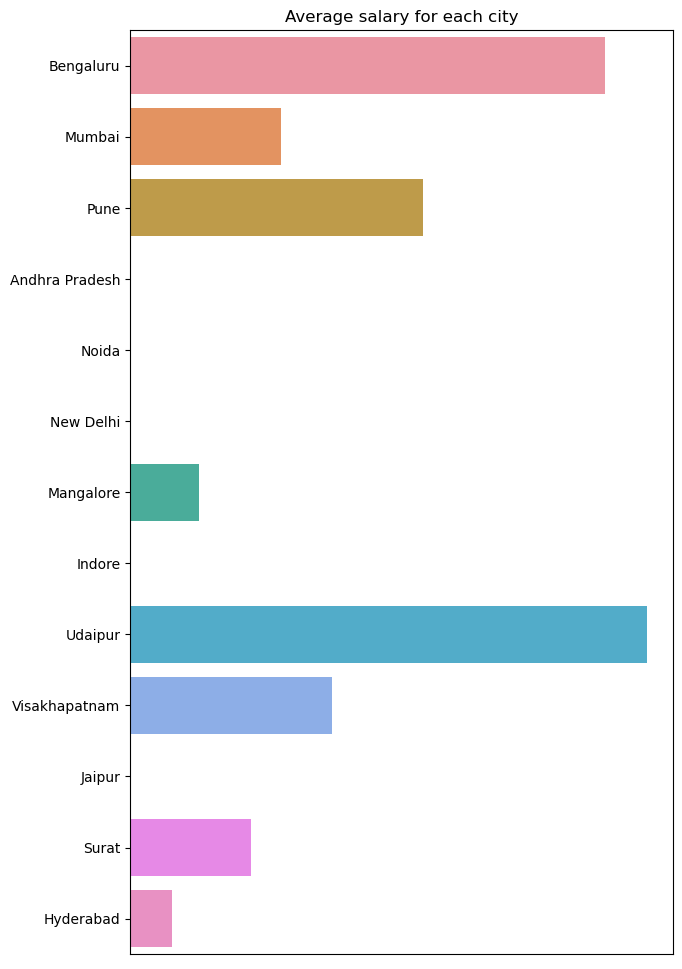

In [48]:
plt.figure(figsize=(7,12))
sns.barplot(y=list(average_sal.keys()),x=list(average_sal.values()))
plt.title("Average salary for each city")
plt.ticklabel_format(style='plain', axis='x',)
plt.xticks(range(0,))
plt.grid(axis="x")
plt.show()

In [49]:
# Calculating average salary for each state

salary_df = np.array(df["Salary per year"])


average_sal = {}

for state in df["State"].unique():
    sal = salary_df[df["State"]==state]
    average_sal[state] = np.nanmean(sal)

for state, avg_salary in average_sal.items():
    print(f'City: {state}, Average Salary: {avg_salary:.2f}')

City: Karnataka, Average Salary: 1553714.29
City: Maharashtra, Average Salary: 966334.56
City: Andhra Pradesh, Average Salary: 702000.00
City: Uttar Pradesh, Average Salary: nan
City: Delhi, Average Salary: nan
City: Madhya Pradesh, Average Salary: nan
City: Rajasthan, Average Salary: 1800000.00
City: Gujarat, Average Salary: 420000.00
City: Telangana, Average Salary: 144000.00


C:\Users\Monika\AppData\Local\Temp\ipykernel_4940\2406353917.py:10: RuntimeWarning: Mean of empty slice
  average_sal[state] = np.nanmean(sal)


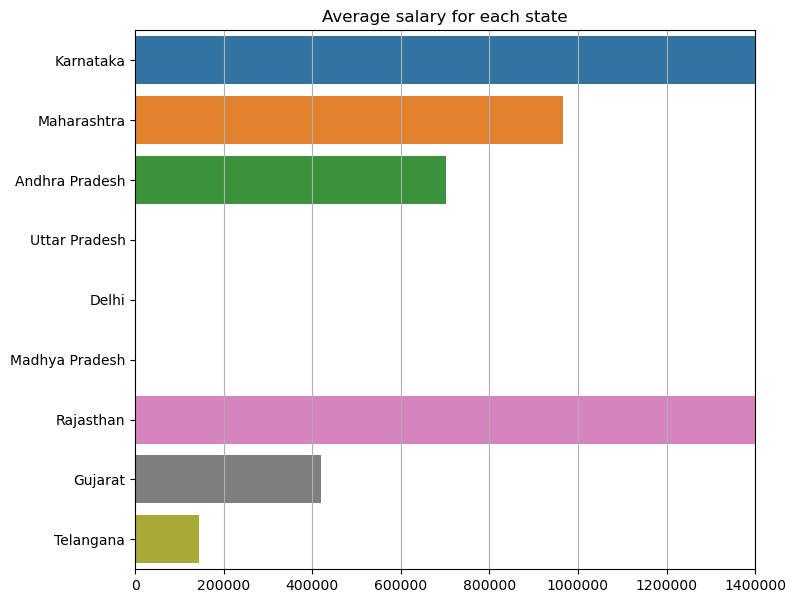

In [41]:
plt.figure(figsize=(8,7))
sns.barplot(y=list(average_sal.keys()),x=list(average_sal.values()))
plt.title("Average salary for each state")
plt.ticklabel_format(style='plain', axis='x')
plt.xlim(0,1400000)
plt.grid(axis="x")
plt.show()